In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter 

##  Plot 2nd. generation release experiment

In [3]:
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/second_gen//"
year_list = np.arange(2007,2017).tolist()
out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24

def read_output(file):
    ds = xr.open_dataset(file)#just use output_paticles for new data
    return ds

def load_ds(year):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/second_gen/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))
    #out_files = sorted(Path(out_path).glob("*zone3*.nc"))
    print(f'loaded {len(out_files)} files in year {year}')
    ds = xr.concat(map(read_output, out_files), dim="traj")
    return ds, ds.traj[-1].values

def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map

In [4]:
#load velocity data mean
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")

x_lines = np.arange(-50,30,10).tolist()#extends of plots
y_lines = np.arange(-10,35,5).tolist()#[18,20,22,24,26,28,30]

u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

ulat = ds_u.coords["nav_lat"].values[:,0]
ulon = ds_u.coords["nav_lon"].values[0,:]

y_ind = np.where((ulat > y_lines[0]) & (ulat < 30))[0]
x_ind = np.where((ulon > x_lines[0]) & (ulon < x_lines[-1]))[0]
    
u_conc = ds_u[:,:,y_ind,x_ind].mean("depthu").mean('time_counter')
v_conc = ds_v[:,:,y_ind,x_ind].mean("depthv").mean('time_counter')

In [5]:
#load 10year mean velocity data
for year in year_list:
    u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc"))
    v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc"))
    
    ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,y_ind,x_ind].mean("depthu").mean('time_counter')
    ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,y_ind,x_ind].mean("depthv").mean('time_counter')
    
    u_conc = xr.concat((u_conc, ds_u), dim = 'year')
    v_conc = xr.concat((v_conc, ds_v), dim = 'year')
    
u_mean = u_conc.mean('year')
v_mean = v_conc.mean('year')

#for quiverplots
ulon = ulon[x_ind]
ulat = ulon[y_ind]

In [6]:
#load bathy
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"
t = xr.open_dataset(data_path / t_file)

t_lat = t.coords["nav_lat"].values[1:,0]
t_lon = t.coords["nav_lon"].values[0,:]

t_sel = t.vosaline[:,:,y_ind,x_ind].sel(time_counter = "2011-01-01")

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int')
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[x_ind],t_lat[y_ind])

In [39]:
#coarse bins
dlat = 1 #binsize
dlon = 1

lat_bins = np.arange(-10, 30 + dlat, dlat)
lon_bins = np.arange(-50,  15 + dlon, dlon)

def yearly_heatmap(year):
    ds,num = load_ds(year)
    heatmap = calculate_heatmap(ds,lat_bins,lon_bins)
    return heatmap,num

heatmap_list = year_list.copy()
scale_list = year_list.copy()

for i, year in enumerate(year_list):
    heatmap_list[i], scale_list[i] = yearly_heatmap(year)
    #print(f'     traj number: {scale_list[i]}')

loaded 16 files in year 2007
loaded 16 files in year 2008
loaded 16 files in year 2009
loaded 16 files in year 2010
loaded 16 files in year 2011
loaded 16 files in year 2012
loaded 16 files in year 2013
loaded 16 files in year 2014
loaded 16 files in year 2015
loaded 16 files in year 2016


In [43]:
hm_concat = xr.concat(heatmap_list, dim = 'year')
ensemble_mean = hm_concat.sum('obs').mean('year')
ensemble_100_mean = hm_concat.isel(obs = slice(0,101)).sum('obs').mean('year')

In [44]:
def slice_quiver(xmin,xmax,ymin,ymax, skip = 10):
    x_inds = np.where((ulon >= xmin) & (ulon <= xmax))[0] 
    y_inds = np.where((ulat >= ymin) & (ulat <= ymax))[0] 

    u  = u_mean.isel(y = y_inds - 275,x = x_inds)[::skip,::skip]
    v  = v_mean.isel(y = y_inds - 275,x = x_inds)[::skip,::skip]

    return ulon[x_inds][::skip], ulat[y_inds][::skip],u,v

In [45]:
ticks = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
cb_pad = 0.07
cb_fraction = 0.047
proj = ccrs.PlateCarree()
textbox = ["0-102 days","0-181 days"]
textbox2 = ["a)","b)"]
cmap = cmo.cm.dense
new_cmap = cmo.tools.crop_by_percent(cmap, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)

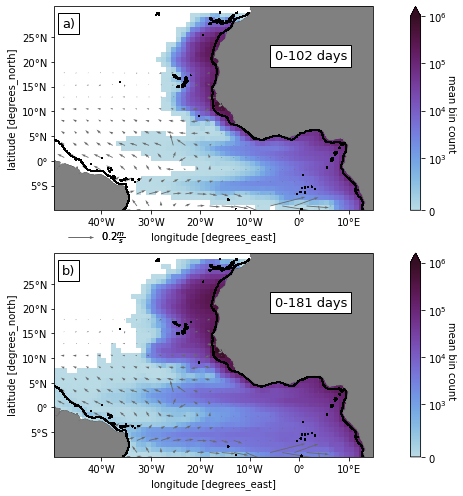

In [46]:
#percentiles
lon = ensemble_mean["lon_bin"]
lat = ensemble_mean["lat_bin"]
quants = ensemble_mean.quantile(q=0.95) # 95% percentile
quants_100 = ensemble_100_mean.quantile(q=0.95) # 50% percentile
hm_t = quants.coords["quantile"].where(ensemble_mean > quants)
hm_t_100 = quants.coords["quantile"].where(ensemble_100_mean > quants_100)


fig, axs = plt.subplots(2, 1, subplot_kw={"projection": proj}, figsize=(15, 7))

axs = axs.flatten()
mesh1 =ensemble_100_mean.where(ensemble_100_mean > 0).plot.pcolormesh(ax = axs[0],cmap = new_cmap,add_colorbar=False,
                                                                      norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e6,
                                                                     base=10), extend = 'max',rasterized = True)#, zorder = )

cbar = fig.colorbar(mesh1, ax =axs[0], pad = cb_pad*0.5, extend = 'max')
cbar.set_label('mean bin count', rotation=270,labelpad = 10,rasterized = True)


#plot2
mesh2 = ensemble_mean.where(ensemble_mean > 0).plot.pcolormesh(ax = axs[1],cmap = new_cmap,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e6,
                                                                     base=10), extend = 'max',rasterized = True)

cbar = fig.colorbar(mesh2, ax =axs[1], pad = cb_pad*0.5, extend = 'max')
    #cbar = axs[1].collections[0].colorbar
cbar.set_label('mean bin count', rotation=270,labelpad = 10,rasterized = True)

for i, ax in enumerate(axs.flat):
    
    skip = 49
    qv = ax.quiver(ulon[::skip], ulat[::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 2.5,
            transform = proj)
    ax.quiverkey(qv, .55, .52, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure',rasterized = True)
    ax.annotate(textbox[i],(-5,20.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    ax.annotate(textbox2[i],(-48,27),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc
    ax.coastlines()
        
    ax.add_feature(cpf.LAND,facecolor='gray',zorder = 2)


    ax.set_xticks(x_lines[1:-1], crs=proj)
    ax.set_yticks(y_lines[1:-1], crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 
    ax.set_extent((-49.5,15,-8.5,27.5))
    
    ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])

plt.tight_layout()
    
#plt.savefig('pics/sec_gen_mean_ens.png', dpi = 300, bbox_inches = 'tight')    
#plt.savefig('pics/sec_gen_mean_ens.svg', format = 'svg', dpi = 700) 
plt.show()

In [48]:
bath = depth_tgrid.squeeze()[1:,:-1]
bath_america = bath.where((bath['nav_lon'] <=-30)&(bath<500))
america_mask = bath_america.isel(x = slice(0,350),y = slice(0,300))

In [49]:
#generate shelf polygon brazil
from shapely.geometry import Polygon, Point

east_border = []
west_border = []
depth_mask = america_mask
for i in range(depth_mask.shape[0]):
    
    lat_slice = depth_mask[i,:]

    nan_inds = ~np.isnan(lat_slice)

    neighbor_mask = np.zeros_like(depth_mask[0,:], dtype=bool)
    neighbor_mask[:-1] |= nan_inds[1:] & np.isnan(lat_slice[:-1]) # Check right neighbor
    neighbor_mask[1:] |= nan_inds[:-1] & np.isnan(lat_slice[1:]) # Check left neighbor

    latitude = depth_mask.nav_lat[i,0]
    
    if np.where(neighbor_mask)[0].size >=1:
        east_index = 0
        west_index = np.where(neighbor_mask)[0][0]
        east_border.append((depth_mask.nav_lon[i,east_index].values, latitude.values))#append index tuple
        west_border.append((depth_mask.nav_lon[i,west_index].values, latitude.values))
        
box_shelf = Polygon((east_border + list(reversed(west_border))))
#box_shelf

In [50]:
#load last timestep
#get trajs htat are in shelf box
def read_shelf_traj(file):
    out_ds = xr.open_dataset(file).compute()
    
    lat_outds = out_ds.isel(obs = 180)['lat'].values
    lon_outds = out_ds.isel(obs = 180)['lon'].values

    points = [Point(lon, lat) for lat, lon in zip(lat_outds, lon_outds)]
    indices = np.array([i for i, point in enumerate(points) if box_shelf.contains(point)])

    shelf_trajs = out_ds.isel(traj = indices)
    
    return shelf_trajs

def load_shelf_traj(year):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/second_gen/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))
    print(f'loaded shelf traj from {len(out_files)} files in year {year}')
    ds = xr.concat(map(read_shelf_traj, out_files), dim="traj")
    return ds

In [51]:
shelf_traj_list = year_list.copy()
for i, year in enumerate(year_list):
    
    shelf_traj_list[i] = load_shelf_traj(year)
    
shelf_traj = xr.concat(shelf_traj_list, dim = 'traj')
shelf_traj

loaded shelf traj from 16 files in year 2007
loaded shelf traj from 16 files in year 2008
loaded shelf traj from 16 files in year 2009
loaded shelf traj from 16 files in year 2010
loaded shelf traj from 16 files in year 2011
loaded shelf traj from 16 files in year 2012
loaded shelf traj from 16 files in year 2013
loaded shelf traj from 16 files in year 2014
loaded shelf traj from 16 files in year 2015
loaded shelf traj from 16 files in year 2016


<xarray.Dataset>
Dimensions:     (traj: 1229, obs: 182)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -6.224 -6.263 -6.302 ... -43.67 -43.93 nan
    lat         (traj, obs) float64 4.821 4.792 4.747 4.713 ... -1.562 -1.56 nan
    z           (traj, obs) float64 16.29 18.11 21.13 23.92 ... 4.534 2.847 nan
    time        (traj, obs) datetime64[ns] 2007-10-02 2007-10-03 ... NaT
    trajectory  (traj, obs) float64 7.53e+03 7.53e+03 7.53e+03 ... 1.006e+04 nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [52]:
land = cpf.NaturalEarthFeature('physical', 'land', \
    scale='110m', edgecolor='k', facecolor=cpf.COLORS['land'])

In [56]:
#genearate high resolution heatmaps 
lat_bins = t_sel.coords['nav_lat'].values[:,0]#change lat bins to VIKING resolution
lon_bins = t_sel.coords['nav_lon'].values[0,:]

for i, year in enumerate(year_list):
    heatmap_list[i], scale_list[i] = yearly_heatmap(year)
    #print(f'     traj number: {scale_list[i]}')

loaded 16 files in year 2007
loaded 16 files in year 2008
loaded 16 files in year 2009
loaded 16 files in year 2010
loaded 16 files in year 2011
loaded 16 files in year 2012
loaded 16 files in year 2013
loaded 16 files in year 2014
loaded 16 files in year 2015
loaded 16 files in year 2016


In [57]:
america_sum = np.zeros((10,181))
for i,hm in enumerate(heatmap_list):
    for j in range(181):

        hm_day = hm.isel(obs = j)
        america_hm = np.where(bath_america<500, hm_day, np.nan)
        america_sum[i,j] = np.nan_to_num(america_hm).sum()

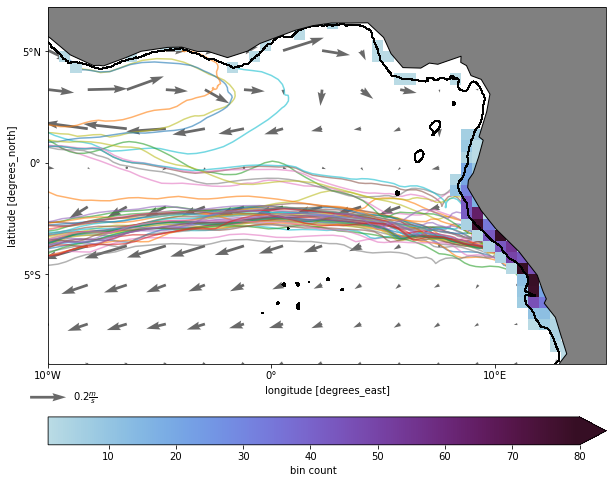

In [95]:
#coarse heatmap for starting area of shelf trajs
start = -51
end = -1
dlat = .5
dlon = .5
clat_bins = np.arange(-10, 20 + dlat, dlat)
clon_bins = np.arange(-19, 15 + dlon, dlon)
cb_kwargs = {'orientation': 'horizontal', 'label':'bin count', 'pad' : cb_pad, 'fraction':cb_fraction}

shelf_traj_hm = calculate_heatmap(shelf_traj, clat_bins,clon_bins).isel(obs = slice(0,1)).mean('obs')
fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(10, 14))

axs.plot(shelf_traj.isel(traj = slice(start,end))['lon'].T,shelf_traj.isel(traj = slice(start, end))['lat'].T, zorder = -1, alpha = .6,rasterized = True)
mesh1 =shelf_traj_hm.where(shelf_traj_hm > 0).plot.pcolormesh(ax = axs,cmap = new_cmap,extend = 'max', zorder = 1, vmax = 80, 
                                                              cbar_kwargs = cb_kwargs,rasterized = True
                                        )

ax =axs
qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-10,15,-9,7, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = .4, zorder = -2,scale_units='inches',
            transform = proj,rasterized = True)
ax.quiverkey(qv, .15, .18, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure',rasterized = True)
ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 

ax.set_extent((-10,15,-9,7))    

cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500],zorder= 1)
for c in cs.collections:
    c.set_rasterized(True)
#plt.savefig('../notebooks/pics/sec_gen_afr_release.png', dpi = 300, bbox_inches = 'tight') 
plt.savefig('../notebooks/pics/sec_gen_afr_release.svg', format = 'svg', dpi = 700) 
plt.show()

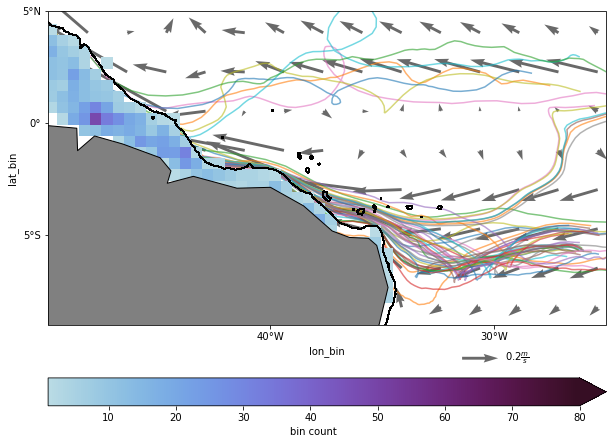

In [94]:
start = -51
end = -1

clat_bins = t_sel.coords['nav_lat'][:,0].coarsen(dim = {'y':10},boundary='trim').mean()
clon_bins = t_sel.coords['nav_lon'][0,:].coarsen(dim = {'x':10},boundary='trim').mean()
x_mesh,y_mesh = np.meshgrid(clon_bins ,clat_bins)

shelf_traj_hm = calculate_heatmap(shelf_traj, clat_bins,clon_bins).isel(obs = slice(-3,-1)).mean('obs')
shelf_traj_hm = shelf_traj_hm.isel(lat_bin = slice(0,36), lon_bin = slice(0, 50))
shelf_traj_hm['lat_bin'] = shelf_traj_hm['lat_bin'] - 0.25 
shelf_traj_hm['lon_bin'] = shelf_traj_hm['lon_bin'] - 0.25 

#cartopy  land scale
cb_kwargs = {'orientation': 'horizontal', 'label':'bin count', 'pad' : cb_pad, 'fraction':cb_fraction}

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(10, 14))


axs.plot(shelf_traj.isel(traj = slice(start,end), obs = slice(100,-1))['lon'].T,
         shelf_traj.isel(traj = slice(start,end), obs = slice(100,-1))['lat'].T, zorder = -1, alpha = .6, lw = 1.5,rasterized = True)


Xmesh_bin, Ymesh_bin  = np.meshgrid(shelf_traj_hm['lon_bin'], shelf_traj_hm['lat_bin'])
mesh1 =shelf_traj_hm.where((shelf_traj_hm > 0)&(shelf_traj_hm['lon_bin'] <= -34.7)).plot.pcolormesh( x = 'lon_bin' , y = 'lat_bin',
                                                                ax = axs,cmap = new_cmap,extend = 'max', zorder = 1, vmax = 80, shading = 'flat',
                                                              cbar_kwargs = cb_kwargs,rasterized = True)

ax =axs
qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-49.9,-25,-10,5, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = .4, zorder = -2,scale_units='inches',
            transform = proj,rasterized = True)
ax.quiverkey(qv, .75, .18, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure',rasterized = True)

ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
ax.set_extent((-49.9,-25,-9,5))    

ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500],zorder= 1)
for c in cs.collections:
    c.set_rasterized(True)
#plt.savefig('pics/sec_gen_brazil_target.png', dpi = 300, bbox_inches = 'tight') 
plt.savefig('../notebooks/pics/sec_gen_brazil_target.svg', format = 'svg', dpi = 700)  
plt.show()

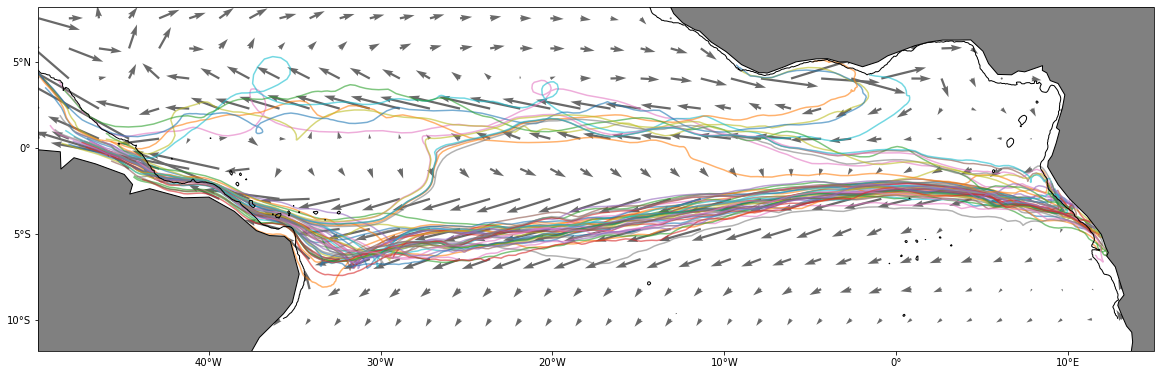

In [93]:
#full atlantic
#NEW START END
start = -51
end = -1

#fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(14, 9))
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(20, 12))

ax.plot(shelf_traj.isel(traj = slice(start,end))['lon'].T,shelf_traj.isel(traj = slice(start,end))['lat'].T, zorder = -1, alpha = .6, rasterized = True)

qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-49.9,15,-10,8, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = .4,width = 0.002,scale_units='inches',
            transform = proj,rasterized = True, zorder = -2)
ax.quiverkey(qv, .75, .18, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure',rasterized = True)

#ax.coastlines()
ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
#ax.set_extent((x_lines[0],15,y_lines[0],29))
ax.set_extent((-49.9,15,-10,7))    
#ax.set_title('Atlantic crossing particles - target region')
cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = True, levels = [500],zorder= 1)
for c in cs.collections:
    c.set_rasterized(True)
#plt.savefig('../notebooks/pics/sec_gen_brazil_target.png', dpi = 300, bbox_inches = 'tight') 
plt.savefig('../notebooks/pics/sec_gen_full_traj.svg', format = 'svg', dpi = 700)  
plt.show()


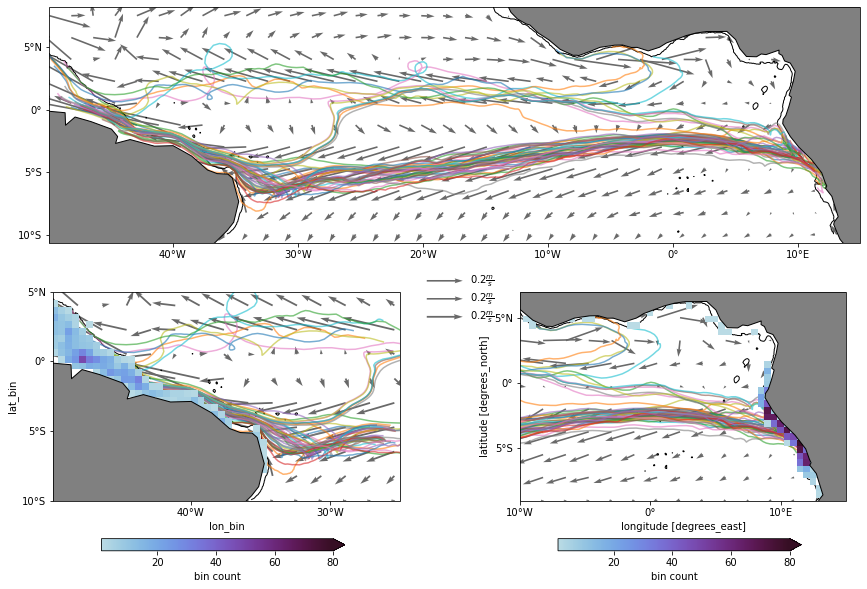

In [91]:
# combine all 3 
import matplotlib.gridspec as gridspec
extend_list = [(-49.9,15,-9,7),(-49.9,-25,-10,5),0,(-10,15,-9,7)]

cb_kwargs = {'orientation': 'horizontal', 'label':'bin count', 'pad' : cb_pad*2.1, 'fraction':cb_fraction}
order_traj = 1
order_qv = -2
order_bins = 2
qv_scale = .4
qv_length = 0.2

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2,height_ratios=[1, 1.1])


#TOP 
ax = fig.add_subplot(gs[0, :], projection = proj)

ax.plot(shelf_traj.isel(traj = slice(start,end))['lon'].T,shelf_traj.isel(traj = slice(start,end))['lat'].T, zorder = order_traj, alpha = .6,rasterized = True)

qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-49.9,15,-10,8, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = qv_scale,width = 0.002,scale_units='inches',linewidth = 5,
            transform = proj,rasterized = True, zorder = order_qv)
ax.quiverkey(qv, .52, .5, qv_length , r'$0.2 \frac{m}{s}$', labelpos='E', linewidth = 5,
                  rasterized = True, coordinates='figure')

#BOT LEFT
ax = fig.add_subplot(gs[1, 0],projection = proj)

ax.plot(shelf_traj.isel(traj = slice(start,end), obs = slice(100,-1))['lon'].T,
         shelf_traj.isel(traj = slice(start,end), obs = slice(100,-1))['lat'].T, zorder = order_traj, alpha = .6, lw = 1.5,rasterized = True)
mesh1 =shelf_traj_hm.where((shelf_traj_hm > 0)&(shelf_traj_hm['lon_bin'] <= -34.7)).plot.pcolormesh(ax = ax,cmap = new_cmap,extend = 'max', zorder = order_bins,vmax = 80, 
                                                              cbar_kwargs = cb_kwargs,rasterized = True)

qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-49.9,-25,-10,5, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = qv_scale, zorder = order_qv,scale_units='inches',
            transform = proj,rasterized = True)
ax.quiverkey(qv, .52, .45, qv_length , r'$0.2 \frac{m}{s}$', labelpos='E', 
                   rasterized = True,coordinates='figure')


#BOT RIGHT
ax = fig.add_subplot(gs[1, 1],projection = proj)

shelf_traj_afr = calculate_heatmap(shelf_traj, clat_bins,clon_bins).isel(obs = slice(0,1)).mean('obs')
ax.plot(shelf_traj.isel(traj = slice(start,end))['lon'].T,shelf_traj.isel(traj = slice(start, end))['lat'].T, zorder = order_traj, alpha = .6,rasterized = True)
mesh1 =shelf_traj_afr.where(shelf_traj_afr > 0).plot.pcolormesh(ax = ax,cmap = new_cmap,extend = 'max', zorder = order_bins, vmax = 80 ,
                                                              cbar_kwargs = cb_kwargs,rasterized = True)
qv_lon,qv_lat,qv_u,qv_v = slice_quiver(-10,15,-9,7, skip = 35)
qv = ax.quiver(qv_lon,qv_lat,qv_u,qv_v, color = 'dimgray', scale = qv_scale, zorder = order_qv,scale_units='inches',
            transform = proj,rasterized = True)
ax.quiverkey(qv, .52, .475, qv_length , r'$0.2 \frac{m}{s}$', labelpos='E', 
                   rasterized = True,coordinates='figure')

for i in [0,1,3]:
    ax = fig.axes[i]
     
    ax.add_feature(land,facecolor='gray',zorder = 2)
    ax.set_xticks(x_lines, crs=proj)
    ax.set_yticks(y_lines, crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 
    cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = True, levels = [500],zorder= -1)
    for c in cs.collections:
        c.set_rasterized(True)
    ax.set_extent(extend_list[i]) 
    
plt.savefig('../notebooks/pics/sec_gen_3plot.svg', format = 'svg', dpi = 700)  
#plt.savefig('pics/fig_S4_sec_gen_3plot.jpg', format = 'jpg', dpi = 700) 

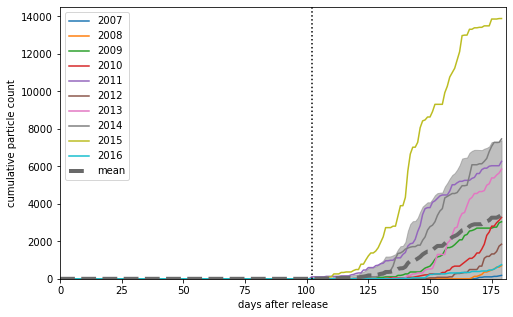

In [96]:
def count_in_shallow(mean_sum):
    return np.cumsum(np.where(np.ediff1d(mean_sum)>0, np.ediff1d(mean_sum),0))

scale_factor = 5.2e6 / 200e3
ame_cumsum = np.zeros_like(america_sum)
plt.figure(figsize = (8,5))
for i in range(10):
    plt.plot(count_in_shallow(america_sum[i,:] * scale_factor), label = str(year_list[i]))
    ame_cumsum[i,1:] = count_in_shallow(america_sum[i,:]) * scale_factor

plt.plot(count_in_shallow(np.mean(america_sum * scale_factor, axis = 0)), lw = 4,c = 'dimgrey',ls = '--', label = 'mean')
neg_std = count_in_shallow(np.mean(america_sum, axis = 0)) *scale_factor - np.std(ame_cumsum, axis = 0)[1:]
pos_std = count_in_shallow(np.mean(america_sum, axis = 0)) *scale_factor+ np.std(ame_cumsum, axis = 0)[1:] 

plt.fill_between(range(180),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5, zorder = 0)
plt.vlines(102,0,18e3,ls = ':', color = '00')

plt.legend()
plt.xlabel('days after release')
plt.ylabel('cumulative particle count')
plt.xlim(0,181)
plt.ylim(0,14.5e3);

#plt.savefig('pics/sec_gen_america_count.png', dpi = 300, bbox_inches = 'tight') 
#plt.savefig('pics/sec_gen_america_count.svg', format = 'svg', dpi = 700)  